In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.transforms as mtransforms


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import roc_auc_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.models import load_model
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(7)
from tensorflow import set_random_seed
set_random_seed(11)


Using TensorFlow backend.


In [2]:
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2


In [3]:
# load  dataset
df = pd.read_csv('/home/francovm/Projects/SSE/data/processed/GISB.csv', sep='\t', encoding='utf-8')

df = df.drop(df.columns[[1, 3, 5]], axis=1)
df.head()

,x,n,u,Events
0,-16.61,-159.10,25.17,1.0
1,-14.99,-158.86,22.46,1.0
2,-15.46,-160.53,22.91,1.0
3,-14.62,-159.06,20.10,1.0
4,-14.13,-160.20,16.44,1.0


[]

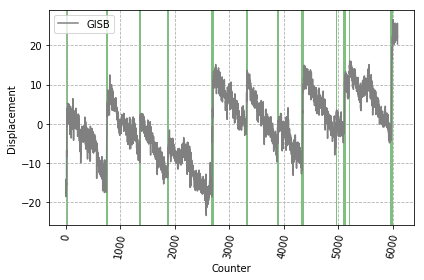

In [4]:
fig, ax = plt.subplots()

plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.plot(dataset_test['Events'],'-', color='gray',label="GISB")
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
# if (dataset_test['Events'] == 0.5): plt.axhline()
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df['Events'])), min(df['Events']), max(df['Events']), where=(df['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

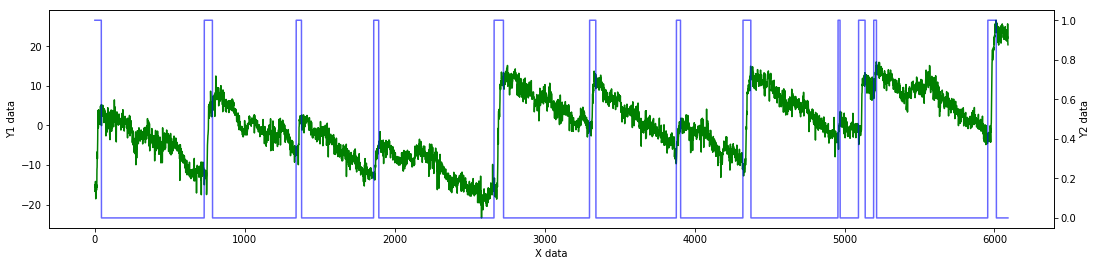

In [5]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df['x'], 'g-')
ax2.plot( df['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

In [6]:
input_X = df.loc[:, df.columns != 'Events'].values  # converts the df to a numpy array
input_y = df['Events'].values

n_features = input_X.shape[1]  # number of features

print(input_X.shape,input_y.shape)

(6091, 3) (6091,)


In [7]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return np.array(X), np.array(y)

## 20 Days Window Time

In [8]:
# Temporalize the data
lookback = 20
X_1, y_gisb_20 = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb_20 = X_1.reshape(X_1.shape[0], lookback, n_features)

In [9]:
print(X_gisb_20.shape,y_gisb_20.shape)

(6070, 20, 3) (6070,)


In [10]:
# plt.plot(y_gisb) # plotting by columns
# plt.plot(df['x'],'-', color='gray',label="GISB")
# plt.show()

In [11]:
# load model
model_20 = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_20days.h5")
# summarize model.
model_20.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [12]:
y_pred_20 = model_20.predict_classes(X_gisb_20)

# predict crisp classes for test set
yhat_prob_20 = model_20.predict_proba(X_gisb_20, verbose=0)

# evaluate the model
scores_20 = model_20.evaluate(X_gisb_20,y_gisb_20)
print((scores_20[1]*100))

6070/6070 [==============================] - 1s 231us/step
94.85996961593628


In [13]:
df_xarray_20 = df['x'].iloc[20:]


In [14]:
df_result_20 = pd.DataFrame(data=[df_xarray_20.values,y_pred_20]).T
df_result_20.columns = ['x','Events']

In [15]:
df_result_20.head()

,x,Events
0,1.3,[1]
1,-0.12,[1]
2,3.77,[1]
3,-0.64,[1]
4,-0.17,[1]


[]

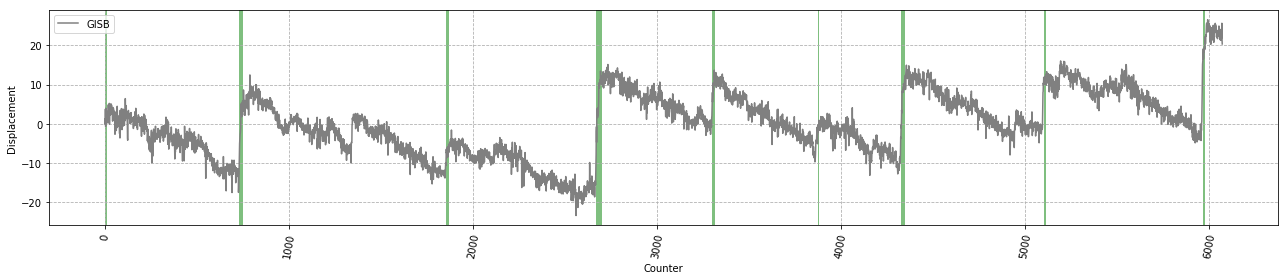

In [16]:
fig, ax = plt.subplots()

plt.plot(df_result_20['x'],'-', color='gray',label="GISB")
# plt.plot(dataset_test['Events'],'-', color='gray',label="GISB")
    # plt.plot_date(visitors2['Date'],visitors2['Visitors'].rolling(5).mean(),'g-',label="Unique Visitors- mean")

    # plt.axvline(x='2018-07-31', color='r', linestyle='--',label="CWB turn off")
plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
# if (dataset_test['Events'] == 0.5): plt.axhline()
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_20['Events'])), min(df_result_20['Events']), max(df_result_20['Events']),
                where=(df_result_20['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

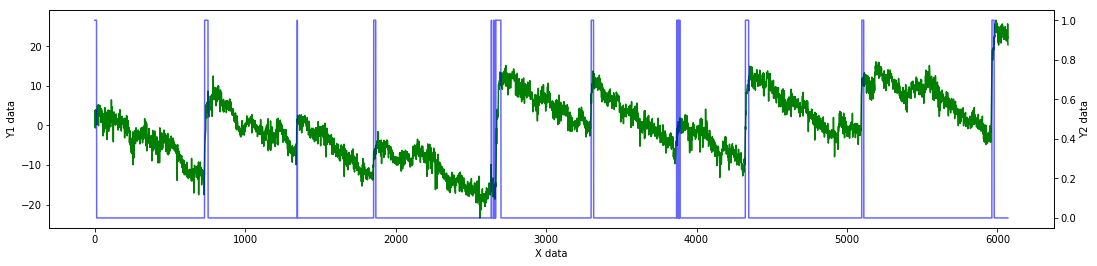

In [17]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_20['x'], 'g-')
ax2.plot( df_result_20['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

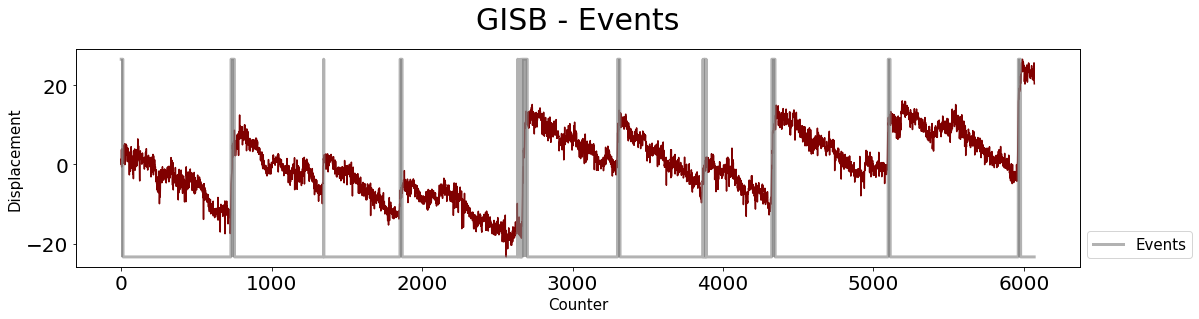

In [18]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_20['x'], '-',color='maroon')
ax2.plot( df_result_20['Events'], '-',color='gray',alpha=0.6,linewidth=3)


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_20.index, 0, 1, where=df_result_20['Events'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('GISB - Events',fontsize=30, ha="center",pad=20)


plt.show()

# 40 days Window Time

In [19]:
# Temporalize the data
lookback = 40
X_1, y_gisb_40 = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb_40 = X_1.reshape(X_1.shape[0], lookback, n_features)

In [20]:
# load model
model_40 = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days.h5")
# summarize model.
model_40.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
y_pred_40 = model_40.predict_classes(X_gisb_40)

# predict crisp classes for test set
yhat_prob_40 = model_40.predict_proba(X_gisb_40, verbose=0)

# evaluate the model
scores_40 = model_40.evaluate(X_gisb_40,y_gisb_40)
print((scores_40[1]*100))

6050/6050 [==============================] - 4s 649us/step
95.98346948623657


In [22]:
df_xarray_40 = df['x'].iloc[40:]
df_result_40 = pd.DataFrame(data=[df_xarray_40.values,y_pred_40]).T
df_result_40.columns = ['x','Events']

[]

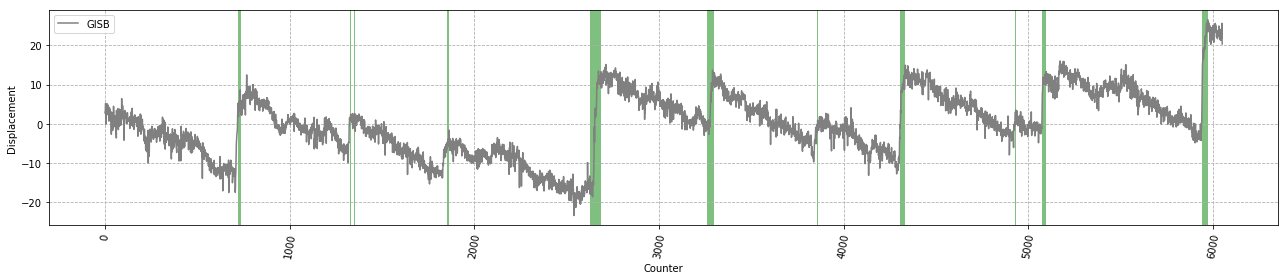

In [23]:
fig, ax = plt.subplots()

plt.plot(df_result_40['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_40['Events'])), min(df_result_40['Events']), max(df_result_40['Events']), 
                where=(df_result_40['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

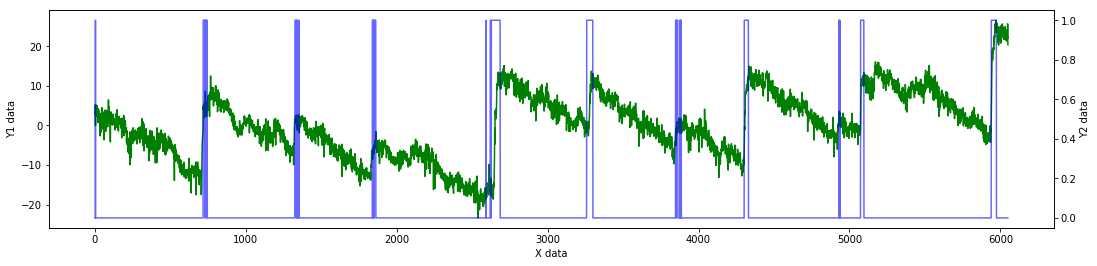

In [24]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40['x'], 'g-')
ax2.plot( df_result_40['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

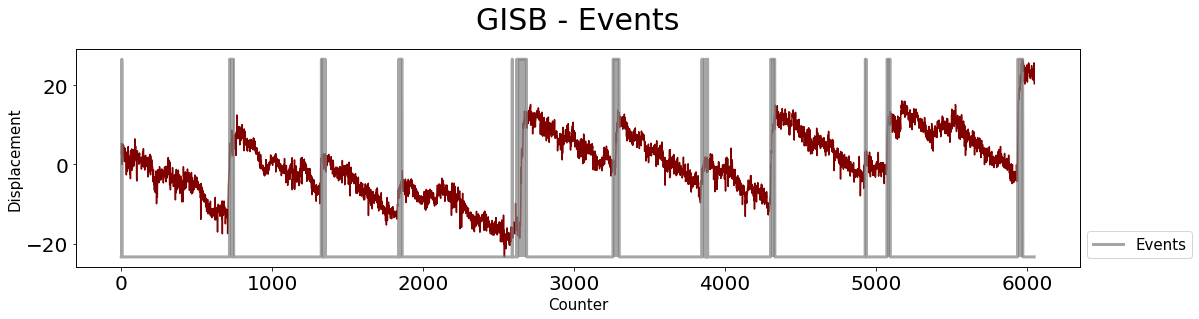

In [25]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40['x'], '-',color='maroon')
ax2.plot( df_result_40['Events'], '-',color='gray',alpha=0.7,linewidth=3)


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_40.index, 0, 1, where=df_result_40['Events'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('GISB - Events',fontsize=30, ha="center",pad=20)


plt.show()

# 40 days Window Time - final

In [26]:
# Temporalize the data
# lookback = 40
# X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

# X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [27]:
# load model
model_40_final = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40window_final.h5")
# summarize model.
model_40_final.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 51,801
Trainable params: 51,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_pred_40_final = model_40_final.predict_classes(X_gisb_40)

# predict crisp classes for test set
yhat_prob_40_final = model_40_final.predict_proba(X_gisb_40, verbose=0)

# evaluate the model
scores_40_final = model_40_final.evaluate(X_gisb_40,y_gisb_40)
print((scores_40_final[1]*100))

6050/6050 [==============================] - 3s 434us/step
96.29752039909363


In [29]:
df_xarray_40_final = df['x'].iloc[40:]
df_result_40_final = pd.DataFrame(data=[df_xarray_40_final.values,y_pred_40_final]).T
df_result_40_final.columns = ['x','Events']

[]

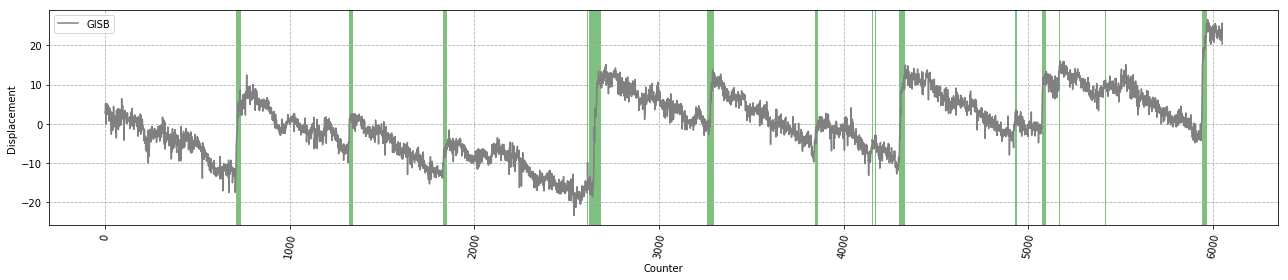

In [30]:
fig, ax = plt.subplots()

plt.plot(df_result_40_final['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_40_final['Events'])), min(df_result_40_final['Events']), 
                max(df_result_40_final['Events']), 
                where=(df_result_40_final['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

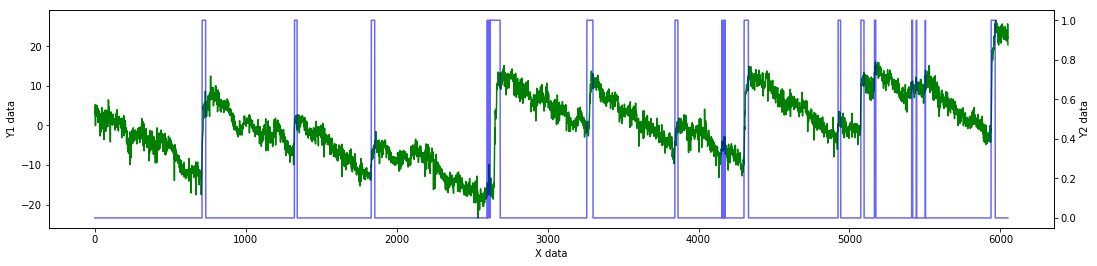

In [31]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40_final['x'], 'g-')
ax2.plot( df_result_40_final['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

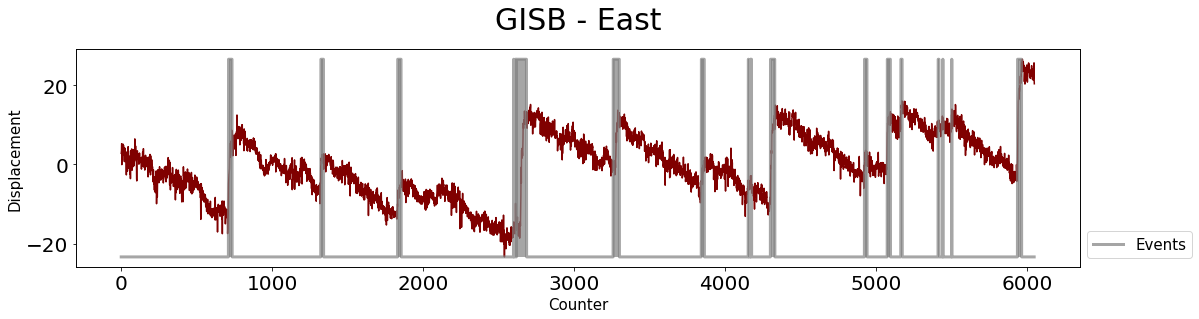

In [32]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_40_final['x'], '-',color='maroon')
ax2.plot( df_result_40_final['Events'], '-',color='gray',alpha=0.7,linewidth=3)


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_40.index, 0, 1, where=df_result_40_final['Events'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('GISB - East',fontsize=30, ha="center",pad=20)


plt.show()

# 5 days Window Time

In [33]:
# Temporalize the data
lookback = 5
X_1, y_gisb_5 = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb_5 = X_1.reshape(X_1.shape[0], lookback, n_features)

In [34]:
# load model
model_5 = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_5days.h5")
# summarize model.
model_5.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [35]:
y_pred_5 = model_5.predict_classes(X_gisb_5)

# predict crisp classes for test set
yhat_prob_5 = model_5.predict_proba(X_gisb_5, verbose=0)

# evaluate the model
scores_5 = model_5.evaluate(X_gisb_5,y_gisb_5)
print((scores_5[1]*100))

6085/6085 [==============================] - 1s 124us/step
92.21035242080688


In [36]:
df_xarray_5 = df['x'].iloc[5:]
df_result_5 = pd.DataFrame(data=[df_xarray_5.values,y_pred_5]).T
df_result_5.columns = ['x','Events']

[]

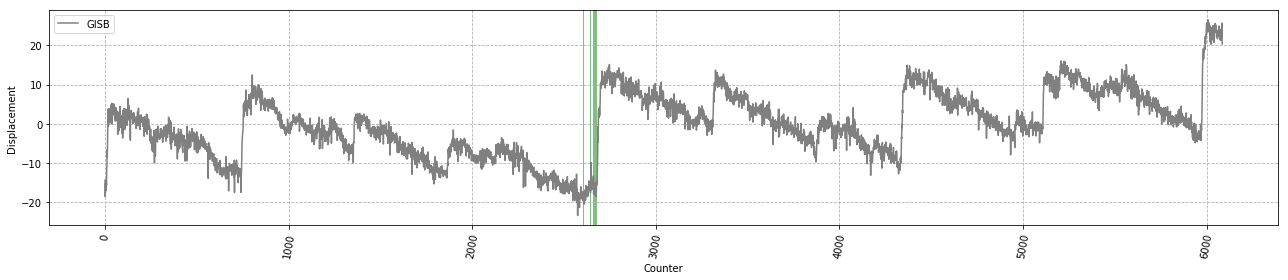

In [37]:
fig, ax = plt.subplots()

plt.plot(df_result_5['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_5['Events'])), min(df_result_5['Events']),\
                max(df_result_5['Events']), 
                where=(df_result_5['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

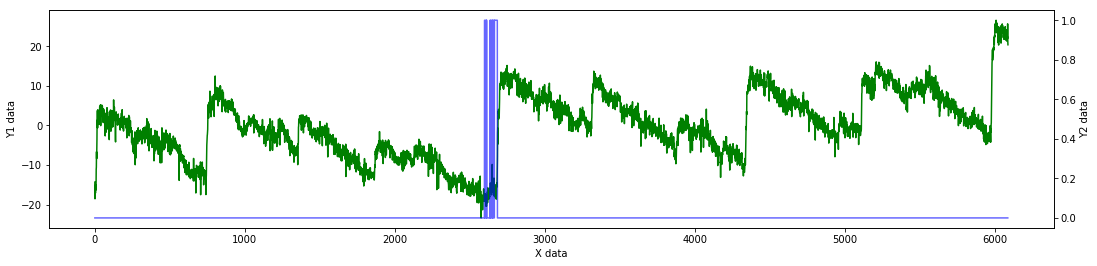

In [38]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_5['x'], 'g-')
ax2.plot( df_result_5['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

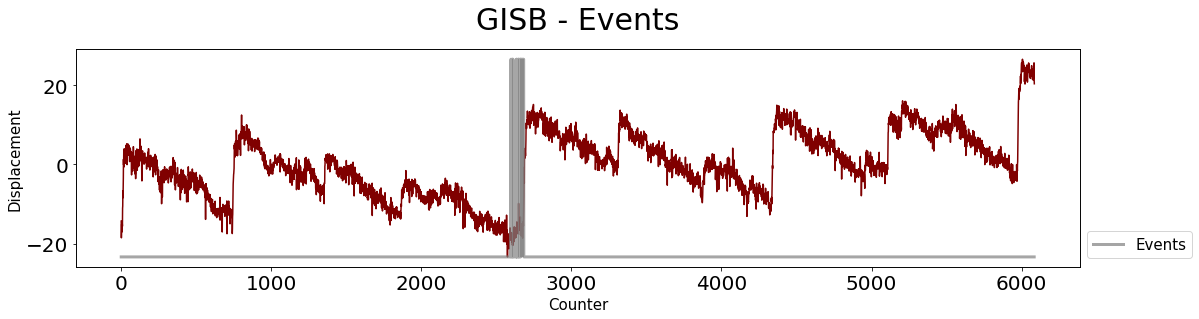

In [39]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_5['x'], '-',color='maroon')
ax2.plot( df_result_5['Events'], '-',color='gray',alpha=0.7,linewidth=3)


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_5.index, 0, 1, where=df_result_5['Events'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('GISB - Events',fontsize=30, ha="center",pad=20)


plt.show()

# 60 days Time Window

In [40]:
# Temporalize the data
lookback = 60
X_1, y_gisb_60 = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb_60 = X_1.reshape(X_1.shape[0], lookback, n_features)

In [41]:
# load model
model_60 = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_60days.h5")
# summarize model.
model_60.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [42]:
y_pred_60 = model_60.predict_classes(X_gisb_60)

# predict crisp classes for test set
yhat_prob_60 = model_60.predict_proba(X_gisb_60, verbose=0)

# evaluate the model
scores_60 = model_60.evaluate(X_gisb_60,y_gisb_60)
print((scores_60[1]*100))

6030/6030 [==============================] - 3s 549us/step
94.85903978347778


In [43]:
df_xarray_60 = df['x'].iloc[60:]
df_result_60 = pd.DataFrame(data=[df_xarray_60.values,y_pred_60]).T
df_result_60.columns = ['x','Events']

[]

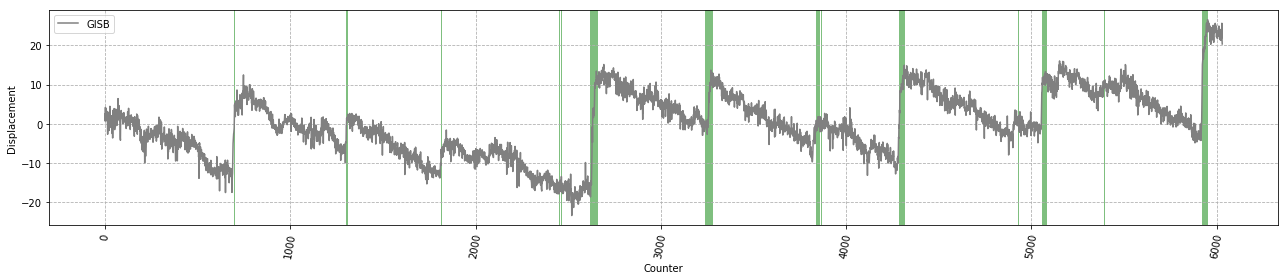

In [44]:
fig, ax = plt.subplots()

plt.plot(df_result_60['x'],'-', color='gray',label="GISB")

plt.legend(loc=2)
plt.xticks( rotation= 80 )

    # Grids
plt.gca().xaxis.grid(True, linestyle='--')
plt.gca().yaxis.grid(True, linestyle='--')

plt.xlabel('Counter')
plt.ylabel('Displacement')
    
    # Get current size
fig_size = plt.rcParams["figure.figsize"]

    # Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size



trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.5
ax.fill_between(range(len(df_result_60['Events'])), min(df_result_60['Events']), max(df_result_60['Events']), 
                where=(df_result_60['Events'] > 0.5), 
                facecolor='green',
                alpha=0.5, transform=trans) 

# plt.show()

plt.tight_layout()
plt.plot()

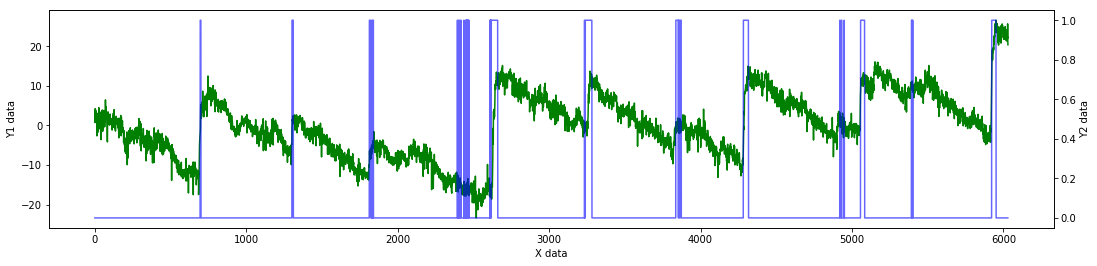

In [45]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_60['x'], 'g-')
ax2.plot( df_result_60['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

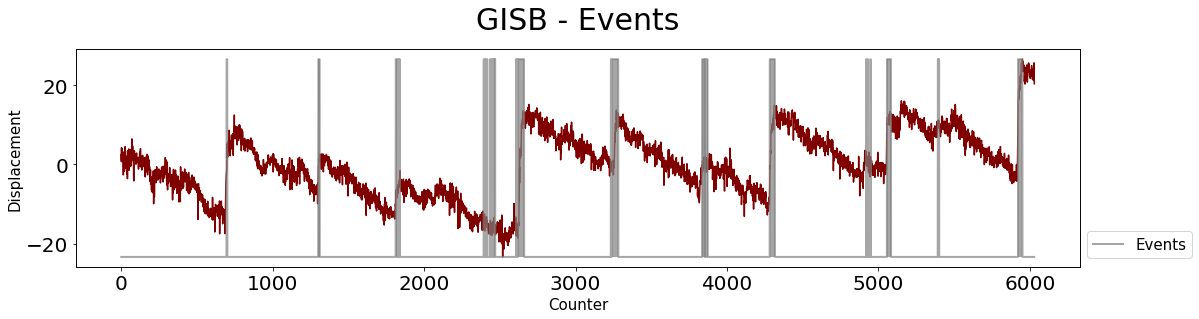

In [46]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_60['x'], '-',color='maroon')
ax2.plot( df_result_60['Events'], '-',color='gray',alpha=0.7,linewidth=2)


# ax2.legend(['Events'], loc=0,fontsize=15)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.2),fontsize=15)

ax1.set_xlabel('Counter',fontsize=15)
ax1.set_ylabel('Displacement',fontsize=15)

###########################################################################
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

ax2.fill_between(df_result_60.index, 0, 1, where=df_result_60['Events'] > 0.5,
                facecolor='gray', alpha=0.7
                )
###################################################################################

ax1.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 20)


plt.yticks([])

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

plt.title('GISB - Events',fontsize=30, ha="center",pad=20)


plt.show()

# ROC for different time windows

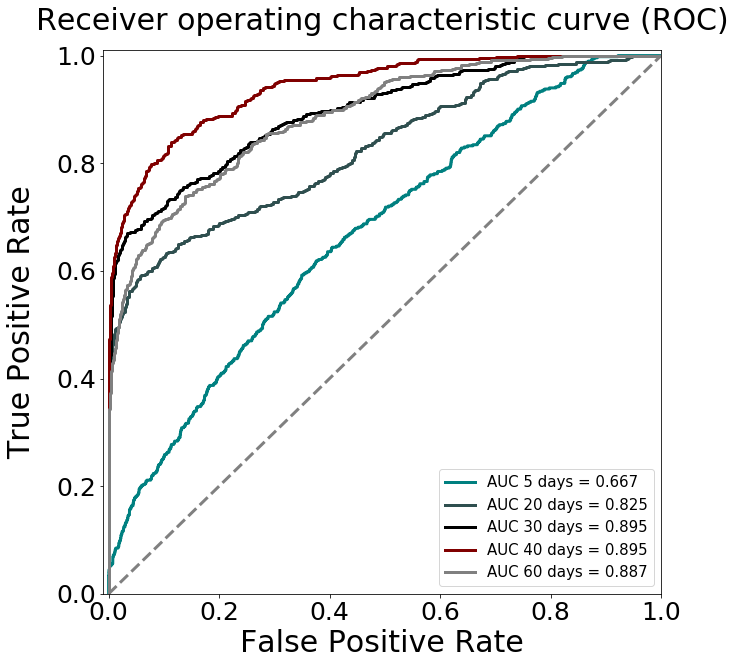

In [96]:


false_pos_rate_5, true_pos_rate_5, thresholds = roc_curve(y_gisb_5, yhat_prob_5)
false_pos_rate_20, true_pos_rate_20, thresholds = roc_curve(y_gisb_20, yhat_prob_20)
false_pos_rate_30, true_pos_rate_30, thresholds = roc_curve(y_gisb_40, yhat_prob_40)
false_pos_rate_40, true_pos_rate_40, thresholds = roc_curve(y_gisb_40, yhat_prob_40_final)
false_pos_rate_60, true_pos_rate_60, thresholds = roc_curve(y_gisb_60, yhat_prob_60)

roc_auc_5 = auc(false_pos_rate_5, true_pos_rate_5,)
roc_auc_20 = auc(false_pos_rate_20, true_pos_rate_20,)
roc_auc_30 = auc(false_pos_rate_30, true_pos_rate_30,)
roc_auc_40 = auc(false_pos_rate_40, true_pos_rate_40,)
roc_auc_60 = auc(false_pos_rate_60, true_pos_rate_60,)

plt.plot(false_pos_rate_5, true_pos_rate_5, linewidth=3, label='AUC 5 days = %0.3f'% roc_auc_5,color='teal')
plt.plot(false_pos_rate_20, true_pos_rate_20, linewidth=3, label='AUC 20 days = %0.3f'% roc_auc_20,color='darkslategray')
plt.plot(false_pos_rate_30, true_pos_rate_30, linewidth=3, label='AUC 30 days = %0.3f'% roc_auc_30,color='black')
plt.plot(false_pos_rate_40, true_pos_rate_40, linewidth=3, label='AUC 40 days = %0.3f'% roc_auc_30,color='maroon')
plt.plot(false_pos_rate_60, true_pos_rate_60, linewidth=3, label='AUC 60 days = %0.3f'% roc_auc_60,color='gray')


plt.plot([0,1],[0,1],'--', linewidth=3,color='gray')

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right',fontsize=15)
plt.title('Receiver operating characteristic curve (ROC)',fontsize=30, ha="center",pad=20)
plt.ylabel('True Positive Rate',fontsize=30,labelpad=20)
plt.xlabel('False Positive Rate',fontsize=30)

# Get current size
fig_size = plt.rcParams["figure.figsize"]
#  Set figure width to 18 and height to 4
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

           
ax = plt.subplot()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# set the grid on

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 25)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 25)

# plt.fill_between( false_pos_rate, true_pos_rate, facecolor='lightgray',alpha=0.4)

# plt.axhline(y=0.952, color='r', linestyle='-')

plt.show()

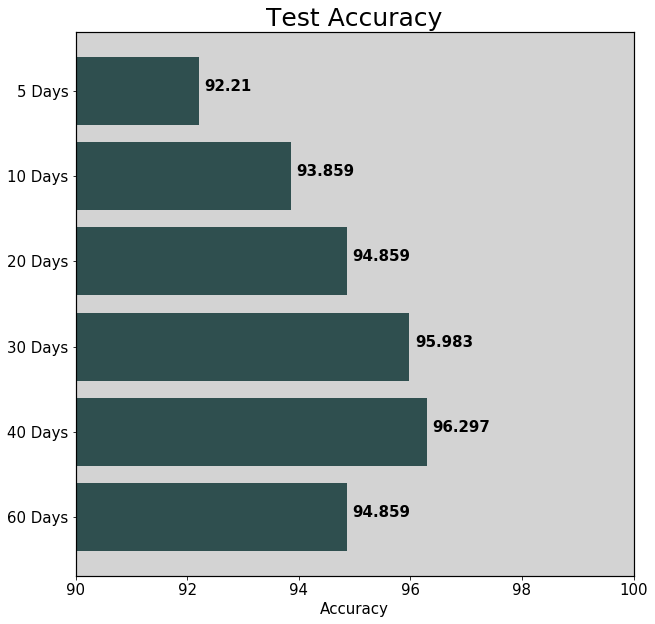

In [118]:
objects = ('60 Days', '40 Days', '30 Days', '20 Days', '10 Days', '5 Days')
y_pos = np.arange(len(objects))

Accuracy = [94.859,96.297,95.983,94.859,93.859,92.210]

plt.barh(y_pos, Accuracy,color='darkslategray', align='center', alpha=1)
plt.yticks(y_pos, objects)
plt.xlabel('Accuracy',fontsize=15)
plt.title('Test Accuracy',fontsize=25)

ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 15)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.2)
    
# fig, ax = plt.subplots()    

bg_color = 'lightgray'
ax.patch.set_facecolor(bg_color)

for i, v in enumerate(Accuracy):
    ax.text(v +0.1, i , str(v), color='black', fontweight='bold',fontsize=15)

plt.xlim(90,100)
plt.show()

# 20 Days time window - Standarization

In [49]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [50]:
# load model
model_stand = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_20days_standarize.h5")
# summarize model.
model_stand.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [51]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [52]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_gisb))

In [53]:
# Standarize the input

X_gisb_scaled = scale(X_gisb, scaler)


In [54]:
a = flatten(X_gisb_scaled)
print('colwise mean', np.mean(a,axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [-0. -0.  0.]
colwise variance [1. 1. 1.]


In [55]:
y_pred_stand = model_stand.predict_classes(X_gisb_scaled)

In [56]:
df_xarray_stand = df['x'].iloc[20:]
df_result_stand = pd.DataFrame(data=[df_xarray_stand.values,y_pred_stand]).T
df_result_stand.columns = ['x','Events']

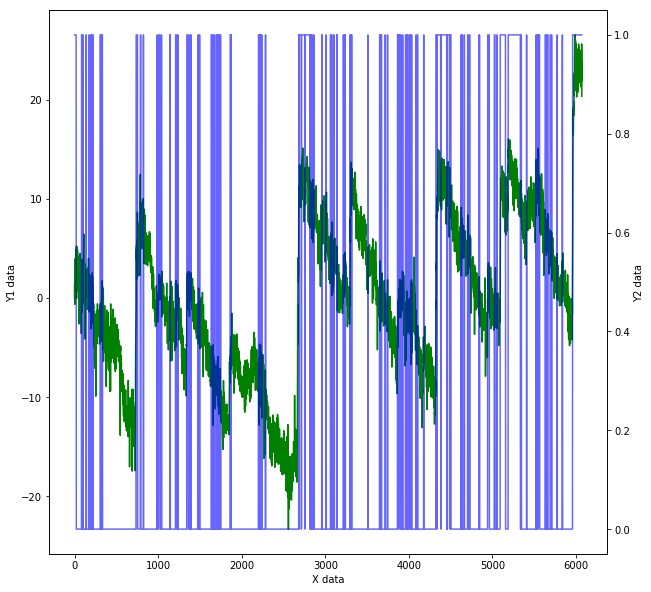

In [57]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_stand['x'], 'g-')
ax2.plot( df_result_stand['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

# 20 Days window time -  pre-SSE mapping

In [58]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [59]:
# load model
model_shifted = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_20days-shifted.h5")
# summarize model.
model_shifted.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [60]:
y_pred_shifted = model_shifted.predict_classes(X_gisb)

In [61]:
df_xarray_shifted = df['x'].iloc[20:]
df_result_shifted = pd.DataFrame(data=[df_xarray_shifted.values,y_pred_shifted]).T
df_result_shifted.columns = ['x','Events']

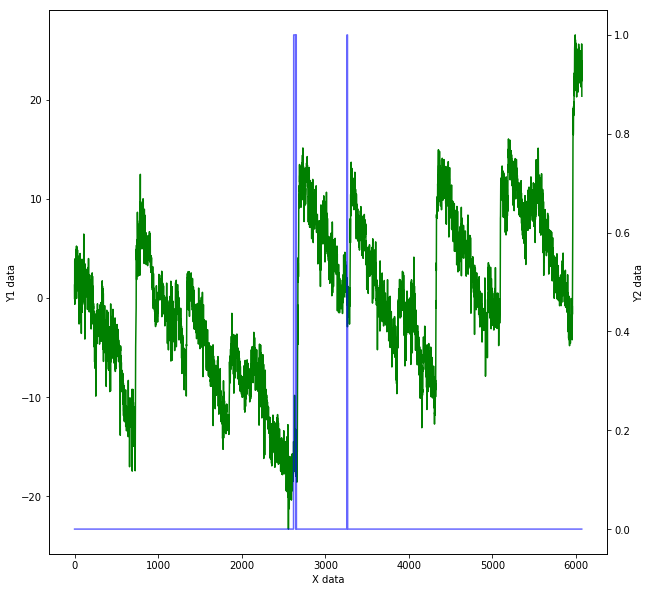

In [62]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted['x'], 'g-')
ax2.plot( df_result_shifted['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

    
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


plt.show()

In [63]:
# evaluate the model
score = model_shifted.evaluate(X_gisb,y_gisb, verbose=1)
print("%s: %.2f%%" % (model_shifted.metrics_names[1], score[1]*100))

6070/6070 [==============================] - 2s 265us/step
accuracy: 91.96%


In [64]:
y_pred_shifted_prob = model_shifted.predict(X_gisb)

In [65]:
df_xarray_shifted_2 = df['x'].iloc[20:]
df_result_shifted_2 = pd.DataFrame(data=[df_xarray_shifted_2.values,y_pred_shifted_prob]).T
df_result_shifted_2.columns = ['x','Events']

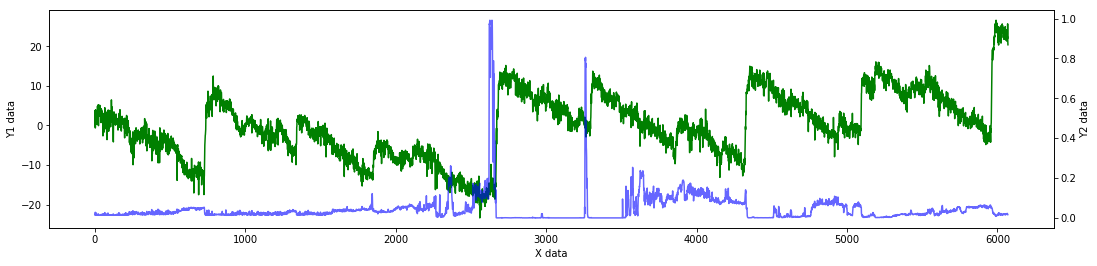

In [66]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted_2['x'], 'g-')
ax2.plot( df_result_shifted_2['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()

In [67]:
# plt.plot(y)

# 40 Days window time -  pre-SSE mapping

In [68]:
# Temporalize the data
lookback = 20
X_1, y_gisb = temporalize(X = input_X, y = input_y, lookback = lookback)

X_gisb = X_1.reshape(X_1.shape[0], lookback, n_features)

In [69]:
# load model
model_shifted = load_model("/home/francovm/Projects/SSE/models/Vanilla/Binary_clasifier_LSTM_SSE_40days-shifted.h5")
# summarize model.
model_shifted.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 50)                10800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 13,401
Trainable params: 13,401
Non-trainable params: 0
_________________________________________________________________


In [70]:
y_pred_shifted = model_shifted.predict_classes(X_gisb)

In [71]:
df_xarray_shifted = df['x'].iloc[20:]
df_result_shifted = pd.DataFrame(data=[df_xarray_shifted.values,y_pred_shifted]).T
df_result_shifted.columns = ['x','Events']

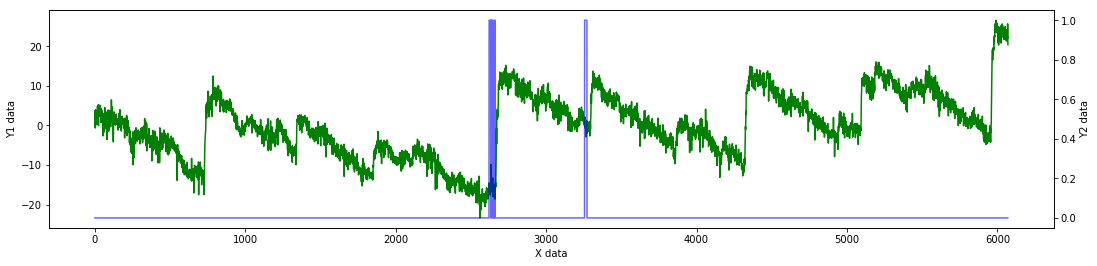

In [72]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted['x'], 'g-')
ax2.plot( df_result_shifted['Events'], 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

    
# Get current size
fig_size = plt.rcParams["figure.figsize"]

# Set figure width to 18 and height to 4
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


plt.show()

In [73]:
# evaluate the model
score = model_shifted.evaluate(X_gisb,y_gisb, verbose=1)
print("%s: %.2f%%" % (model_shifted.metrics_names[1], score[1]*100))

6070/6070 [==============================] - 2s 274us/step
accuracy: 91.83%


In [74]:
y_pred_shifted_prob = model_shifted.predict(X_gisb)

In [75]:
df_xarray_shifted_2 = df['x'].iloc[20:]
df_result_shifted_2 = pd.DataFrame(data=[df_xarray_shifted_2.values,y_pred_shifted_prob]).T
df_result_shifted_2.columns = ['x','Events']

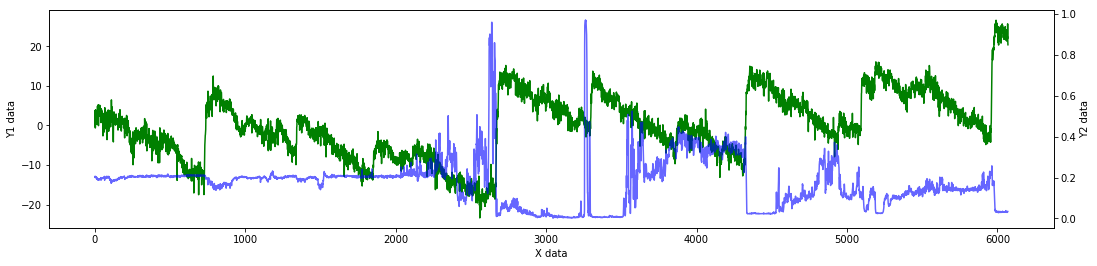

In [76]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot( df_result_shifted_2['x'], 'g-')
ax2.plot( np.sqrt(y_pred_shifted_prob), 'b-',alpha=0.6)

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data')
ax2.set_ylabel('Y2 data')

plt.show()